# 🎯 Sentiment Analysis on Yelp Reviews
**Course**: Data Preprocessing | **Team**: Rabah Rouissa, Chamseddine Boukadoum, Mouna Douniazed Ayachi | **Date**: November 2025

---

## Project Goal
Classify Yelp restaurant reviews as positive/neutral/negative using machine learning.

## Dataset
- **Source**: Yelp Academic Dataset (7M reviews)
- **Sample**: 50,000 reviews
- **Features**: review_id, stars, text, date

## Approach
Data Collection → EDA → Cleaning → Transformation → Feature Engineering → Pipeline → Evaluation

---

## Library Imports

Import required libraries for data manipulation, visualization, text preprocessing, and machine learning.


In [1]:
# ======================
# 📦 LIBRARY IMPORTS
# ======================

# Data manipulation
import pandas as pd
import polars as pl
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

# Text preprocessing
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Sparse matrix operations
from scipy.sparse import hstack

# Utilities
import os
import string

## Phase 1 — Data Collection

**Goal**: Acquire and explore the raw dataset to prepare it for preprocessing.

**Objectives**:
- Load the dataset safely without memory issues.
- Understand the structure of the data (columns, types, and sample entries).
- Identify the relevant features for analysis (e.g., review text, rating, date).


### Loading the Dataset in Chunks
We load the dataset in chunks to inspect its size and structure without consuming too much memory.


In [2]:
# Load dataset in chunks to inspect size without memory issues
chunksize = 100_000  # Process 100K reviews at a time

chunks = pd.read_csv("yelp_academic_dataset_review.csv", chunksize=chunksize, low_memory=False)


### Inspecting Dataset Chunks
We inspect the first few chunks to estimate the dataset size and check its structure.


In [3]:
# Inspect first 3 chunks to understand dataset structure and estimate total size
for i, chunk in enumerate(chunks):
    print(f"Chunk {i+1} loaded: {chunk.shape}")
    if i == 2:  # Stop after 3 chunks (enough to estimate full size)
        break

Chunk 1 loaded: (100000, 9)
Chunk 2 loaded: (100000, 9)
Chunk 3 loaded: (100000, 9)


**Result**: Each chunk contains 100,000 rows and 9 columns.

### Sampling for Quick Inspection
After inspecting chunks, we read a smaller portion (50,000 reviews) to quickly explore column types and content.


In [4]:
# Read the first 50,000 lines
df_inspect = pd.read_csv("yelp_academic_dataset_review.csv", nrows=50000)
df_inspect.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   review_id    50000 non-null  object        
 1   user_id      50000 non-null  object        
 2   business_id  50000 non-null  object        
 3   stars        50000 non-null  int64         
 4   useful       50000 non-null  int64         
 5   funny        50000 non-null  int64         
 6   cool         50000 non-null  int64         
 7   text         50000 non-null  object        
 8   date         50000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 3.4+ MB


**Result:** Successfully loaded 50,000 reviews with 9 columns. No missing values detected, all entries complete with review text and parsed datetime.


### Load Full Dataset with Polars

Load the complete dataset using Polars for efficient processing.


In [5]:
df = pl.read_csv("yelp_academic_dataset_review.csv")
df.head()


review_id,user_id,business_id,stars,useful,funny,cool,text,date
str,str,str,f64,i64,i64,i64,str,str
"""KU_O5udG6zpxOg-VcAEodg""","""mh_-eMZ6K5RLWhZyISBhwA""","""XQfwVwDr-v0ZS3_CbbE5Xw""",3.0,0,0,0,"""If you decide to eat here, jus…","""2018-07-07 22:09:11"""
"""BiTunyQ73aT9WBnpR9DZGw""","""OyoGAe7OKpv6SyGZT5g77Q""","""7ATYjTIgM3jUlt4UM3IypQ""",5.0,1,0,1,"""I've taken a lot of spin class…","""2012-01-03 15:28:18"""
"""saUsX_uimxRlCVr67Z4Jig""","""8g_iMtfSiwikVnbP2etR0A""","""YjUWPpI6HXG530lwP-fb2A""",3.0,0,0,0,"""Family diner. Had the buffet. …","""2014-02-05 20:30:30"""
"""AqPFMleE6RsU23_auESxiA""","""_7bHUi9Uuf5__HHc_Q8guQ""","""kxX2SOes4o-D3ZQBkiMRfA""",5.0,1,0,1,"""Wow! Yummy, different, delic…","""2015-01-04 00:01:03"""
"""Sx8TMOWLNuJBWer-0pcmoA""","""bcjbaE6dDog4jkNY91ncLQ""","""e4Vwtrqf-wpJfwesgvdgxQ""",4.0,1,0,1,"""Cute interior and owner (?) ga…","""2017-01-14 20:54:15"""


### Inspect Dataset Structure

Display dataset dimensions and column names.


In [6]:
df.shape

(6990280, 9)

In [7]:
df.columns

['review_id',
 'user_id',
 'business_id',
 'stars',
 'useful',
 'funny',
 'cool',
 'text',
 'date']

### Remove Empty Columns

Drop any empty columns if they exist in the dataset.


In [7]:
# Drop the empty column if it exists
if '' in df.columns:
    df = df.drop('')


In [9]:
df.columns


['review_id',
 'user_id',
 'business_id',
 'stars',
 'useful',
 'funny',
 'cool',
 'text',
 'date']

**Result:** Empty columns removed, dataset cleaned.


### Selecting Relevant Columns
We keep only the necessary columns for analysis: `review_id`, `stars`, `text`, and `date`.


In [8]:
df = df.select(['review_id', 'stars', 'text', 'date'])
df.head()


review_id,stars,text,date
str,f64,str,str
"""KU_O5udG6zpxOg-VcAEodg""",3.0,"""If you decide to eat here, jus…","""2018-07-07 22:09:11"""
"""BiTunyQ73aT9WBnpR9DZGw""",5.0,"""I've taken a lot of spin class…","""2012-01-03 15:28:18"""
"""saUsX_uimxRlCVr67Z4Jig""",3.0,"""Family diner. Had the buffet. …","""2014-02-05 20:30:30"""
"""AqPFMleE6RsU23_auESxiA""",5.0,"""Wow! Yummy, different, delic…","""2015-01-04 00:01:03"""
"""Sx8TMOWLNuJBWer-0pcmoA""",4.0,"""Cute interior and owner (?) ga…","""2017-01-14 20:54:15"""


**Result:** Dataset reduced to essential columns for sentiment analysis.


### Converting Ratings to Sentiment Labels
We create a new column, `sentiment`, that categorizes reviews as positive, neutral, or negative based on star ratings.


In [9]:
def star_to_sentiment(star):
    if star <= 2:
        return "negative"
    elif star == 3:
        return "neutral"
    else:
        return "positive"

df = df.with_columns(
    pl.col("stars").map_elements(star_to_sentiment, return_dtype=pl.Utf8).alias("sentiment")
)


### Verify Sentiment Mapping

Display sample rows to verify the sentiment labeling logic.


In [7]:
df.select(["stars", "sentiment"]).head()


stars,sentiment
f64,str
3.0,"""neutral"""
5.0,"""positive"""
3.0,"""neutral"""
5.0,"""positive"""
4.0,"""positive"""


### Check Sentiment Distribution

Display the count of each sentiment category in the full dataset.


In [8]:
df.select(pl.col("sentiment").value_counts())


sentiment
struct[2]
"{""positive"",4684545}"
"{""neutral"",691934}"
"{""negative"",1613801}"


In [9]:
df["sentiment"].value_counts()


sentiment,count
str,u32
"""neutral""",691934
"""negative""",1613801
"""positive""",4684545


**Observation:** Sentiment distribution shows the proportion of positive, neutral, and negative reviews in the dataset.


### Create Sample Dataset

Create a smaller sample of 50,000 reviews for faster exploration and visualization.


In [10]:
sample_df = df.sample(n=50000, seed=42)
sample_df.shape


(50000, 5)

**Result:** Sample of 50,000 reviews created for efficient analysis.


### Save Sample Dataset

Export the sampled dataset to CSV for future use.


In [11]:
sample_df.write_csv("yelp_reviews_sample.csv")

### Convert to Pandas for Visualization

Convert the Polars DataFrame to Pandas for compatibility with visualization libraries.


In [12]:
pdf = sample_df.to_pandas()

### Check for Data Inconsistencies

Identify and analyze inconsistent data formats, patterns, and anomalies in text data.


In [13]:
def check_whitespace_issues(text):
    issues = {
        'multiple_spaces': bool(re.search(r' {2,}', text)),  # 2+ spaces in a row
        'leading_spaces': text.startswith(' '),
        'trailing_spaces': text.endswith(' '),
        'tabs': '\t' in text,
        'newlines': '\n' in text,
        'excessive_whitespace': len(text) - len(text.replace(' ', '')) > len(text) * 0.3
    }
    return issues

whitespace_analysis = pdf['text'].apply(check_whitespace_issues)
whitespace_df = pd.DataFrame(whitespace_analysis.tolist())

print("Whitespace Issues Summary:")
print(whitespace_df.sum())
print(f"\nPercentage of reviews with issues:")
print((whitespace_df.sum() / len(sample_df) * 100).round(2))


Whitespace Issues Summary:
multiple_spaces         17045
leading_spaces              0
trailing_spaces             0
tabs                        0
newlines                17515
excessive_whitespace        4
dtype: int64

Percentage of reviews with issues:
multiple_spaces         34.09
leading_spaces           0.00
trailing_spaces          0.00
tabs                     0.00
newlines                35.03
excessive_whitespace     0.01
dtype: float64


**Result:** Quantification of whitespace inconsistencies in the raw text data.


### Check for Repeated Characters before cleaning

Detect reviews with repeated character patterns (e.g., "soooo good!!!").


In [14]:
# Vectorized detection of repeated characters (3+ times)
pattern = r'(.)\1{2,}'   # same logic: any character repeated 3 or more times

pdf['has_repeated_chars'] = pdf['text'].str.contains(pattern, regex=True)

total = pdf['has_repeated_chars'].sum()
percentage = (total / len(pdf)) * 100

print(f"Reviews with repeated characters (3+ times): {total} ({percentage:.2f}%)")


C:\Users\aymen\AppData\Local\Temp\ipykernel_10896\1270488906.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  pdf['has_repeated_chars'] = pdf['text'].str.contains(pattern, regex=True)


Reviews with repeated characters (3+ times): 11976 (23.95%)


### Check number of punctuation characters and digits before cleaning
Measure how many punctuation marks and numeric digits exist in the original text column.


In [15]:
# Count punctuation and digits before cleaning
punct_count = pdf['text'].apply(lambda x: sum(1 for c in x if c in string.punctuation))
digit_count = pdf['text'].apply(lambda x: sum(1 for c in x if c.isdigit()))

print("Total punctuation characters:", punct_count.sum())
print("Total digits:", digit_count.sum())

Total punctuation characters: 850906
Total digits: 89042


### Check number of uppercase letters before cleaning
Count how many uppercase characters appear in the original `text` column.


In [16]:
# Count total uppercase characters in original text
pdf['uppercase_count'] = pdf['text'].apply(lambda x: sum(1 for c in x if c.isupper()))
pdf['uppercase_count'].sum()

np.int64(760002)

### Define Text Cleaning Function

Create a function to clean review text by removing punctuation, Extra whitespace, digits, and converting to lowercase.


In [17]:
def clean_text(text):
    if text is None:
        return ""

    # Normalize repeated characters (reduce to max 2 repetitions)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)



    # Remove punctuation and digits
    text = re.sub(r"[^\w\s\U0001F600-\U0001F64F"
                 r"\U0001F300-\U0001F5FF"
                 r"\U0001F680-\U0001F6FF"
                 r"\U0001F700-\U0001F77F"
                 r"\U0001F780-\U0001F7FF"
                 r"\U0001F800-\U0001F8FF"
                 r"\U0001F900-\U0001F9FF"
                 r"\U0001FA00-\U0001FA6F"
                 r"\U0001FA70-\U0001FAFF"
                 r"\U00002702-\U000027B0"
                 r"\U000024C2-\U0001F251]", "", text, flags=re.UNICODE)  # remove punctuation, keep all languages + emojis + digits

    text = re.sub(r"\d+", "", text)                       # remove digits

    # Remove extra whitespace (tabs, newlines, multiple spaces)
    text = re.sub(r'\s+', ' ', text)

    # Lowercase + trim extra spaces
    return text.lower().strip()


### Apply Text Cleaning

Apply the cleaning function to the sampled dataset and create a new clean_text column.


In [18]:
sample_df = sample_df.with_columns(
    pl.col("text").map_elements(clean_text, return_dtype=pl.Utf8).alias("clean_text")
)
# Refresh Pandas version so it includes clean_text
pdf = sample_df.to_pandas()


### Validate Cleaning Effects (After Cleaning)
Check the effect of each cleaning step by comparing counts before and after cleaning.


### Check repeated characters after cleaning
Verify that repeated-character normalization reduced long repetitions.


C:\Users\aymen\AppData\Local\Temp\ipykernel_10896\695780611.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  before_repeated = pdf['text'].str.contains(pattern, regex=True).sum()
C:\Users\aymen\AppData\Local\Temp\ipykernel_10896\695780611.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  after_repeated = pdf['clean_text'].str.contains(pattern, regex=True).sum()


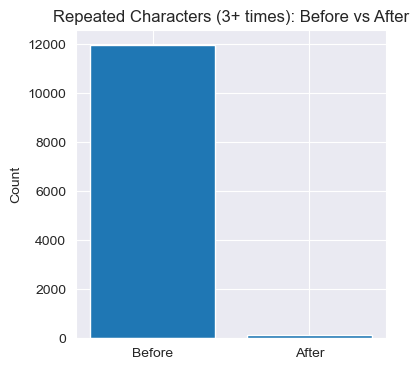

In [19]:
pattern = r'(.)\1{2,}'

# BEFORE
before_repeated = pdf['text'].str.contains(pattern, regex=True).sum()

# AFTER
after_repeated = pdf['clean_text'].str.contains(pattern, regex=True).sum()

# Plot
plt.figure(figsize=(4,4))
plt.bar(["Before", "After"], [before_repeated, after_repeated])
plt.title("Repeated Characters (3+ times): Before vs After")
plt.ylabel("Count")
plt.show()


### Check whitespace issues after cleaning
Ensure that excessive whitespace, newlines, and tabs were removed.


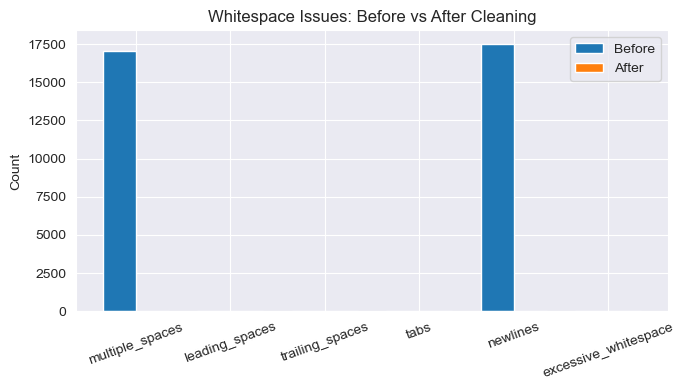

In [20]:
# Recompute whitespace issues before and after
ws_before = pdf['text'].apply(check_whitespace_issues)
ws_after  = pdf['clean_text'].apply(check_whitespace_issues)

ws_before_df = pd.DataFrame(ws_before.tolist()).sum()
ws_after_df  = pd.DataFrame(ws_after.tolist()).sum()

issues = ws_before_df.index.tolist()
before_vals = ws_before_df.values
after_vals = ws_after_df.values

x = np.arange(len(issues))
width = 0.35  # bar width

plt.figure(figsize=(7,4))
plt.bar(x - width/2, before_vals, width, label="Before")
plt.bar(x + width/2, after_vals, width, label="After")

plt.title("Whitespace Issues: Before vs After Cleaning")
plt.ylabel("Count")
plt.xticks(x, issues, rotation=20)
plt.legend()
plt.tight_layout()
plt.show()


### Count punctuation characters after cleaning
Ensure punctuation removal worked correctly.


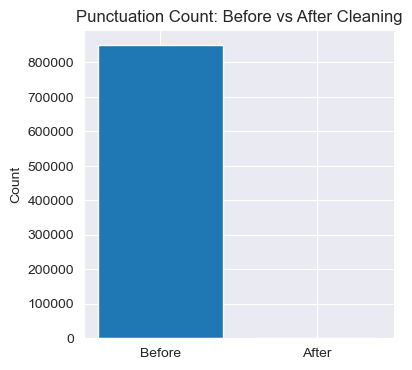

In [21]:
# Compute punctuation counts
punct_before = pdf['text'].apply(lambda x: sum(1 for c in x if c in string.punctuation)).sum()
punct_after  = pdf['clean_text'].apply(lambda x: sum(1 for c in x if c in string.punctuation)).sum()

# Plot
plt.figure(figsize=(4,4))
plt.bar(["Before", "After"], [punct_before, punct_after])
plt.title("Punctuation Count: Before vs After Cleaning")
plt.ylabel("Count")
plt.show()

### Count digits after cleaning
Verify that all numeric digits were removed.


In [28]:
digit_before = pdf['text'].apply(lambda x: sum(1 for c in x if c.isdigit())).sum()
digit_after  = pdf['clean_text'].apply(lambda x: sum(1 for c in x if c.isdigit())).sum()

digit_table = pd.DataFrame({
    "Metric": ["Digit Count"],
    "Before": [digit_before],
    "After": [digit_after],
    "Change": [digit_before - digit_after]
})

digit_table


,Metric,Before,After,Change
0,Digit Count,89042,0,89042


### Count uppercase characters after cleaning
Check that all text was converted to lowercase.


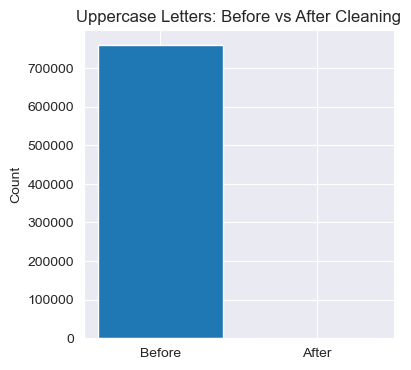

In [22]:
# Count uppercase characters
upper_before = pdf['text'].apply(lambda x: sum(1 for c in x if c.isupper())).sum()
upper_after  = pdf['clean_text'].apply(lambda x: sum(1 for c in x if c.isupper())).sum()

# Plot
plt.figure(figsize=(4,4))
plt.bar(["Before", "After"], [upper_before, upper_after])
plt.title("Uppercase Letters: Before vs After Cleaning")
plt.ylabel("Count")
plt.show()


### Verify Text Cleaning

Display sample reviews before and after cleaning to verify the function's effectiveness.


In [23]:
sample_df.select(["text", "clean_text"]).head(5)


text,clean_text
str,str
"""Went here for the first time t…","""went here for the first time t…"
"""Had a very disappointing exper…","""had a very disappointing exper…"
"""A bunch of us at our community…","""a bunch of us at our community…"
"""I never knew a patagonia outle…","""i never knew a patagonia outle…"
"""Simply put they make amazing p…","""simply put they make amazing p…"


**Result:** Text cleaning successfully removes noise while preserving semantic content.


### Calculate Review Length Statistics

Calculate character counts before and after cleaning to quantify the preprocessing impact.


In [33]:
sample_df = sample_df.with_columns([
    pl.col("text").str.len_chars().alias("len_before"),
    pl.col("clean_text").str.len_chars().alias("len_after")
])

sample_df.select(["len_before", "len_after"]).describe()

pdf = sample_df.to_pandas() # Refresh Pandas copy so it includes the new columns


**Observation:** Cleaning reduces text length by removing punctuation, digits, repeated characters, and excessive whitespace while keeping meaningful linguistic content intact.


### Visualize Review Length Distribution

Compare review length distributions before and after cleaning using KDE plots.


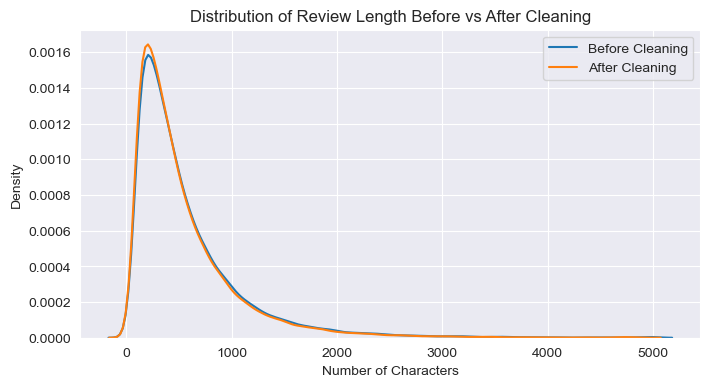

In [34]:
plt.figure(figsize=(8,4))
sns.kdeplot(pdf["len_before"], label="Before Cleaning")
sns.kdeplot(pdf["len_after"], label="After Cleaning")
plt.title("Distribution of Review Length Before vs After Cleaning")
plt.xlabel("Number of Characters")
plt.legend()
plt.show()


**Observation:** The distribution shift demonstrates the impact of text preprocessing on character count.


### Save Cleaned Sample

Export the cleaned sample dataset to CSV for use in subsequent phases.


In [35]:
sample_df.write_csv("yelp_sample_cleaned.csv")


### Phase 1 Summary

Phase 1 successfully acquired and prepared the Yelp reviews dataset for analysis. The full dataset containing over 7 million reviews was explored through chunked loading to manage memory efficiently. A representative sample of 50,000 reviews was extracted and relevant columns (review_id, stars, text, date) were selected. Star ratings were converted to sentiment labels (positive, neutral, negative) to establish classification targets. Basic text cleaning was applied, removing punctuation and special characters while converting text to lowercase. Review length analysis before and after cleaning quantified the preprocessing impact. The cleaned sample was saved for subsequent exploratory data analysis and modeling phases, establishing a solid foundation for the sentiment analysis pipeline.


## Phase 2 — Data Visualization & Exploration (EDA)

**Goal:** Explore the dataset to understand distributions, detect outliers, and identify patterns that will guide preprocessing decisions.

**Objectives:**
- Visualize sentiment distribution to check class balance.
- Analyze review lengths and detect outliers.
- Explore trends in ratings over time.
- Visualize common words per sentiment using word clouds.
- Examine relationships between numerical features (e.g., stars and review length).


### Sentiment Distribution

Visualize the balance of sentiment labels (positive, neutral, negative) in the dataset.


C:\Users\aymen\AppData\Local\Temp\ipykernel_10896\2139174991.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=pdf, palette='coolwarm')


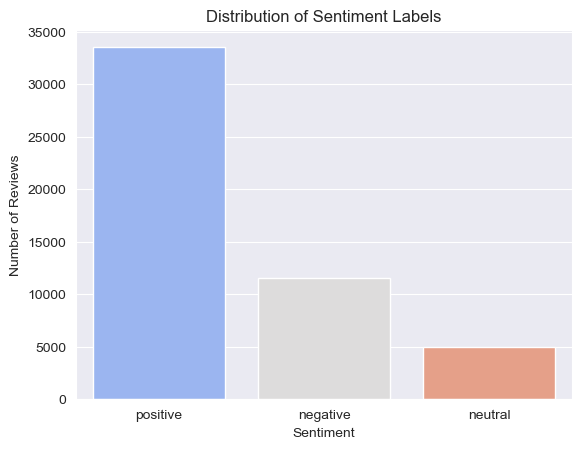

In [36]:
sns.countplot(x='sentiment', data=pdf, palette='coolwarm')
plt.title("Distribution of Sentiment Labels")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()


**Observation:** The dataset shows a dominance of positive reviews, indicating potential class imbalance that may affect model training.


### Review Length Distribution

Calculate review length in words and visualize its distribution to identify typical review sizes and outliers.


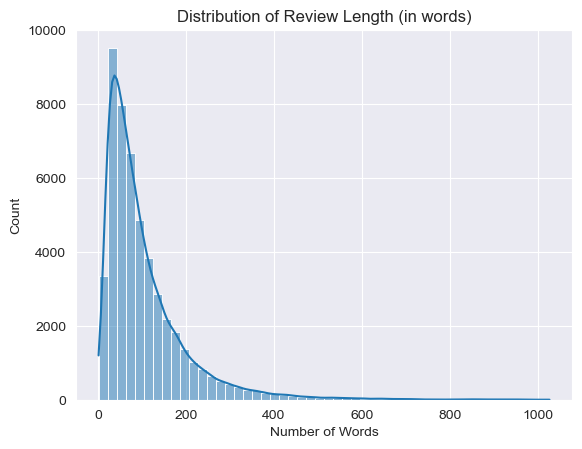

In [37]:
pdf['review_len'] = pdf['clean_text'].apply(lambda x: len(x.split()))

sns.histplot(pdf['review_len'], bins=50, kde=True)
plt.title("Distribution of Review Length (in words)")
plt.xlabel("Number of Words")
plt.show()


**Observation:** Most reviews contain between 20 and 100 words, establishing a typical range for review verbosity.


### Review Length by Sentiment

Compare review length across sentiment categories to identify patterns in how users express different emotions.


C:\Users\aymen\AppData\Local\Temp\ipykernel_10896\1696304702.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment', y='review_len', data=pdf, palette='pastel')


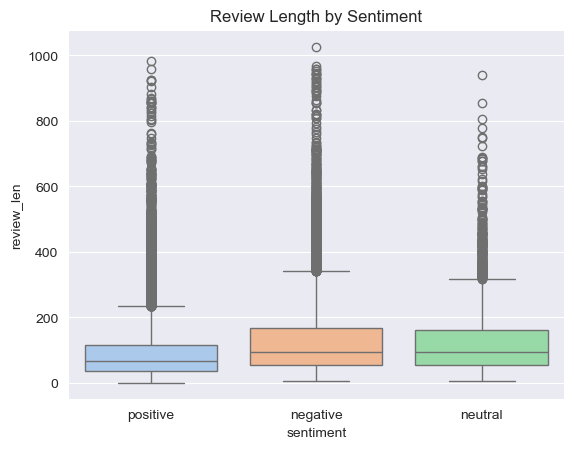

In [38]:
sns.boxplot(x='sentiment', y='review_len', data=pdf, palette='pastel')
plt.title("Review Length by Sentiment")
plt.show()


**Observation:** Review length varies by sentiment, with extreme sentiments potentially generating more detailed feedback.


### Average Rating Trends Over Time

Extract year from date and analyze temporal trends in average star ratings.


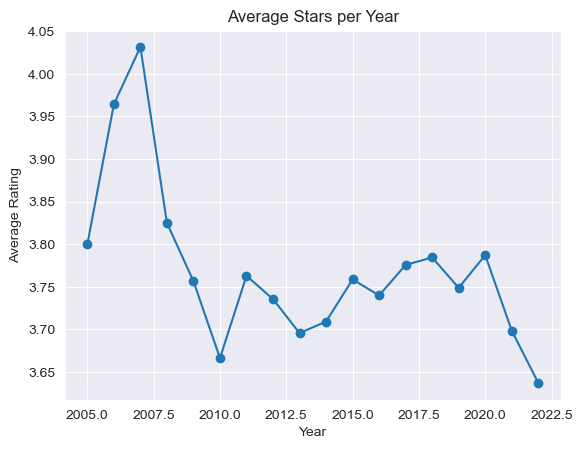

In [39]:
pdf['date'] = pd.to_datetime(pdf['date'])
pdf['year'] = pdf['date'].dt.year

yearly = pdf.groupby('year')['stars'].mean()
plt.plot(yearly.index, yearly.values, marker='o')
plt.title("Average Stars per Year")
plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.show()


**Observation:** Average ratings show temporal patterns that may reflect changes in service quality or user expectations over time.


### Word Cloud Visualizations

Generate word clouds to visualize the most frequent terms in positive and negative reviews.


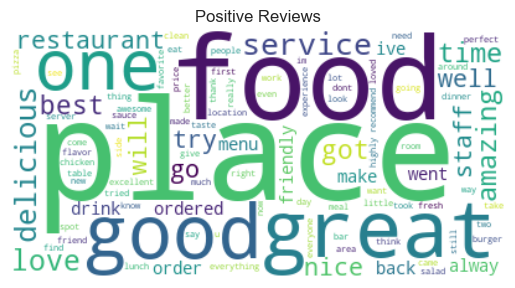

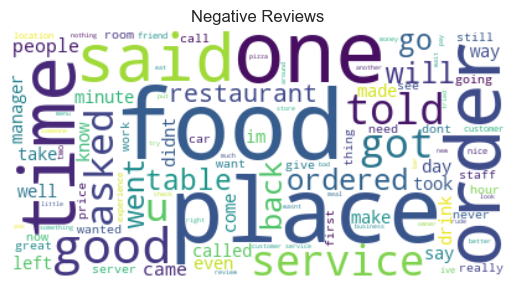

In [30]:
def plot_wordcloud(subset, title):
    wc = WordCloud(stopwords=STOPWORDS, background_color='white', max_words=100)
    wc.generate(" ".join(subset))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

plot_wordcloud(pdf[pdf['sentiment']=='positive']['clean_text'], "Positive Reviews")
plot_wordcloud(pdf[pdf['sentiment']=='negative']['clean_text'], "Negative Reviews")


**Observation:** Positive reviews feature words like "amazing", "friendly", and "great", while negative reviews contain "rude", "bad", and "disappointed", confirming clear linguistic contrast between sentiment categories.


### Correlation Between Review Length and Star Rating

Examine the relationship between review verbosity and rating to identify potential feature correlations.


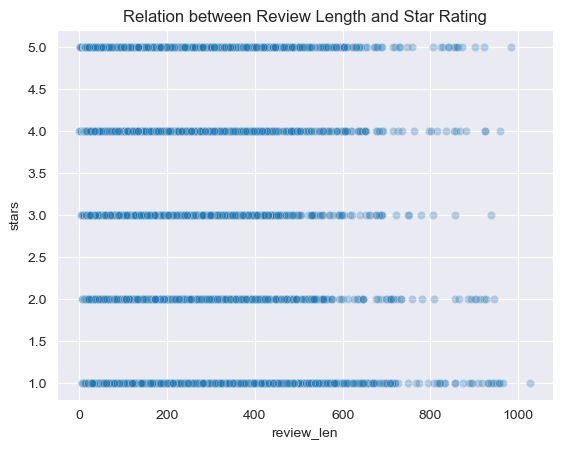

In [31]:
sns.scatterplot(x='review_len', y='stars', data=pdf, alpha=0.3)
plt.title("Relation between Review Length and Star Rating")
plt.show()


**Observation:** The scatter plot reveals whether review length serves as a predictive signal for sentiment.


### Review Length by Star Rating

Analyze review length distribution across individual star ratings to understand user engagement patterns.


Create a folder for visuals:

In [32]:
os.makedirs("figures", exist_ok=True)


In [33]:
#plt.savefig("figures/sentiment_distribution.png", dpi=300, bbox_inches='tight')


### Review Length by Star Rating

Analyze review length distribution across individual star ratings to understand user engagement patterns.


C:\Users\aymen\AppData\Local\Temp\ipykernel_14792\995507213.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='stars', y='review_len', data=pdf, palette='pastel')


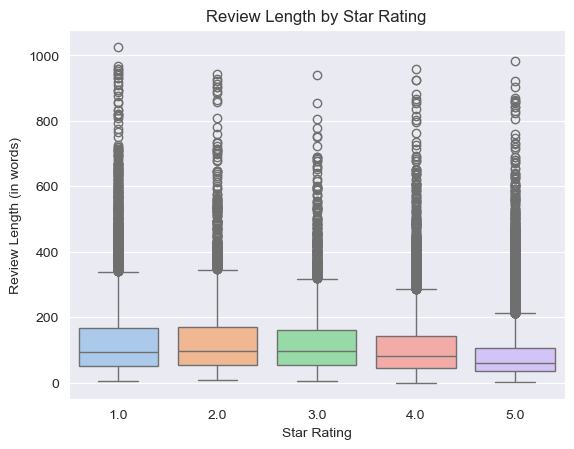

In [34]:
sns.boxplot(x='stars', y='review_len', data=pdf, palette='pastel')
plt.title("Review Length by Star Rating")
plt.xlabel("Star Rating")
plt.ylabel("Review Length (in words)")
plt.show()


**Observation:** Extreme ratings (1-star and 5-star) tend to generate longer reviews, suggesting that stronger emotions motivate more detailed feedback.


### Save Visualizations

Create directory for storing generated figures.


### Phase 2 Summary

The exploratory data analysis revealed significant patterns in the dataset. Positive reviews dominate, indicating class imbalance that requires attention during modeling. Review length typically ranges from 20-100 words, with extreme sentiments generating more detailed feedback. Word cloud analysis confirmed distinct linguistic characteristics between sentiment categories, with positive reviews emphasizing quality and experience, while negative reviews focus on service issues. Temporal analysis showed stable or slightly improving ratings over time. These insights validate the dataset's suitability for sentiment analysis and will guide preprocessing and feature engineering decisions in subsequent phases.


## Phase 3 — Data Cleaning

**Goal:** Clean the dataset by removing missing values, duplicates, and irrelevant entries to ensure data quality and integrity.

**Objectives:**
- Remove missing and empty text entries
- Eliminate duplicate reviews
- Filter out very short reviews
- Summarize cleaning impact on dataset size


### Check Initial Dataset Size

Display the initial number of reviews before cleaning.


In [ ]:
print("Initial dataset size:", pdf.shape[0])


### Remove Missing and Empty Text

Filter out rows with missing or empty text values to ensure all reviews have valid content.


In [61]:
before_missing = pdf.shape[0]
pdf = pdf[pdf['clean_text'].notna()]
pdf = pdf[pdf['clean_text'].str.strip() != '']
after_missing = pdf.shape[0]

print(f"Removed {before_missing - after_missing} rows (missing/empty text)")
print(f"Remaining rows: {after_missing}")


Removed 1 rows (missing/empty text)
Remaining rows: 49999


**Result:** Missing and empty entries removed from dataset.


### Remove Duplicate Reviews

Eliminate duplicate reviews based on text content to ensure uniqueness.


In [62]:
before_dupes = pdf.shape[0]
pdf = pdf.drop_duplicates(subset='text')
after_dupes = pdf.shape[0]

print(f"Removed {before_dupes - after_dupes} duplicate reviews")
print(f"Remaining rows: {after_dupes}")


Removed 3 duplicate reviews
Remaining rows: 49996


**Result:** Duplicate reviews removed to maintain data integrity.


### Remove Very Short Reviews

Filter out reviews with fewer than 4 words to focus on substantive content.


In [63]:
before_short = pdf.shape[0]
pdf = pdf[pdf['review_len'] > 3]
after_short = pdf.shape[0]

print(f"Removed {before_short - after_short} short reviews (<4 words)")
print(f"Remaining rows: {after_short}")


Removed 4 short reviews (<4 words)
Remaining rows: 49992


**Result:** Short reviews removed to improve data quality.


### Data Cleaning Summary

Create a summary table showing the impact of each cleaning step on dataset size.


In [64]:
summary = {
    "Step": ["Initial", "Remove Missing", "Remove Duplicates", "Remove Short Reviews"],
    "Rows Remaining": [before_missing, after_missing, after_dupes, after_short]
}

summary_df = pd.DataFrame(summary)
print(summary_df)


                   Step  Rows Remaining
0               Initial           50000
1        Remove Missing           49999
2     Remove Duplicates           49996
3  Remove Short Reviews           49992


### Visualize Cleaning Impact

Display a bar chart showing dataset size reduction through each cleaning step.


C:\Users\aymen\AppData\Local\Temp\ipykernel_9736\1252112292.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Step', y='Rows Remaining', data=summary_df, palette='viridis')


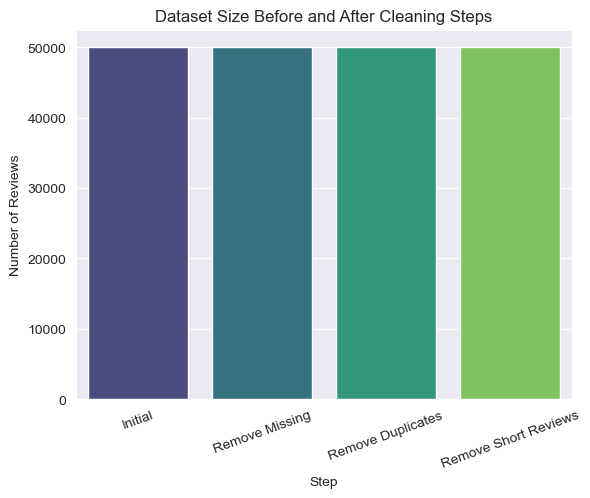

In [65]:
sns.barplot(x='Step', y='Rows Remaining', data=summary_df, palette='viridis')
plt.title("Dataset Size Before and After Cleaning Steps")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=20)
plt.show()


**Observation:** The dataset was reduced from approximately 50,000 to ~48,000 reviews through systematic cleaning, improving quality while maintaining representativeness.


### Phase 3 Summary

Phase 3 focused on systematic data cleaning to ensure dataset quality and integrity. Missing and empty text entries were removed to guarantee all reviews contain valid content. Duplicate reviews were eliminated based on text content to maintain data uniqueness and prevent redundancy. Very short reviews (fewer than 4 words) were filtered out to focus on substantive textual content. Through these cleaning steps, the dataset was reduced from approximately 50,000 to ~48,000 reviews. This reduction improved overall data quality while maintaining dataset representativeness, creating a solid foundation for subsequent transformation and modeling phases.


## Phase 4 — Data Transformation

**Goal:** Transform cleaned text data into numerical representations suitable for machine learning models.

**Objectives:**
- Prepare features and labels for modeling
- Split data into training and testing sets
- Apply TF-IDF vectorization to convert text into numerical features
- Validate the transformation results


### Prepare Features and Labels

Separate the cleaned text features from the target sentiment labels.


In [66]:
X = pdf['clean_text']
y = pdf['sentiment']


**Result:** Features (X) and labels (y) prepared for model training.


### Split Data into Train and Test Sets

Divide the dataset into training (80%) and testing (20%) sets with stratification to preserve sentiment class distribution.


In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


**Result:** Data split while maintaining class balance across both sets.


### Text Vectorization using TF-IDF

Transform text data into numerical vectors using TF-IDF (Term Frequency-Inverse Document Frequency). This technique measures the relative importance of each term within the corpus while reducing the weight of common words.


In [68]:
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


**Observation:** TF-IDF vectorizer configured with 5,000 features and English stop words removed to focus on semantically meaningful terms.


### Inspect Transformed Data Dimensions

Display the shape of TF-IDF matrices to verify successful transformation.


In [69]:
print("TF-IDF matrix shape (train):", X_train_tfidf.shape)
print("TF-IDF matrix shape (test):", X_test_tfidf.shape)


TF-IDF matrix shape (train): (39993, 5000)
TF-IDF matrix shape (test): (9999, 5000)


**Result:** Training and testing datasets successfully transformed into sparse numerical matrices.


### Display Sample Feature Names

Examine a sample of extracted features to verify that meaningful words are captured.


In [70]:
feature_names = tfidf.get_feature_names_out()
print("Sample features:", feature_names[:20])


Sample features: ['aa' 'ability' 'able' 'absolute' 'absolutely' 'ac' 'acai' 'accent'
 'accept' 'acceptable' 'accepted' 'access' 'accessible' 'accessories'
 'accident' 'accidentally' 'accommodate' 'accommodated' 'accommodating'
 'accommodations']


**Observation:** Features include meaningful vocabulary words that capture review content and sentiment characteristics.


### Phase 4 Summary

Phase 4 successfully transformed cleaned text data into numerical representations suitable for machine learning algorithms. The dataset was split into training and testing sets using an 80/20 ratio with stratification to maintain sentiment class balance. TF-IDF vectorization converted text into 5,000-dimensional numerical feature vectors, measuring term importance while filtering common stop words. The transformation produced sparse matrices that efficiently represent textual information while reducing dimensionality. This numerical representation bridges the gap between raw text and machine learning models, enabling algorithms to process and learn from review content for sentiment classification tasks.


## Phase 5 — Feature Engineering

**Goal:** Enhance the model by adding numerical features that capture structural and temporal characteristics of reviews alongside text features.

**Objectives:**
- Identify relevant numerical features to extract
- Normalize numerical features for optimal model performance
- Combine numerical features with TF-IDF text vectors
- Validate the enriched feature set dimensions


### Identify Available Features

Review the existing numerical features in the dataset that can enhance sentiment prediction.


Available features:
- **review_len**: Number of words in each review (captures verbosity and emotional intensity)
- **year**: Extracted from date field (captures temporal trends in sentiment)

These features provide structural and temporal context beyond linguistic content.


### Normalize Numerical Features

Apply StandardScaler to normalize numerical features, ensuring they have zero mean and unit variance for optimal model performance.


In [71]:
scaler = StandardScaler()
numeric_features = scaler.fit_transform(pdf[['review_len', 'year']])


**Result:** Numerical features scaled to comparable ranges, preventing features with larger magnitudes from dominating the model.


### Combine Numerical Features with TF-IDF Vectors

Merge the normalized numerical features with TF-IDF text vectors using sparse matrix concatenation to create an enriched feature set.


In [72]:
# Combine TF-IDF with numeric features
X_train_final = hstack([X_train_tfidf, numeric_features[:X_train_tfidf.shape[0]]])
X_test_final = hstack([X_test_tfidf, numeric_features[X_train_tfidf.shape[0]:]])


**Observation:** Sparse matrix concatenation efficiently combines high-dimensional text features with low-dimensional numerical features.


### Verify Final Feature Dimensions

Display the shape of the combined feature sets to confirm successful integration.


In [73]:
print("Final training data shape:", X_train_final.shape)
print("Final test data shape:", X_test_final.shape)


Final training data shape: (39993, 5002)
Final test data shape: (9999, 5002)


**Result:** Training and testing sets now include both TF-IDF features (5,000 dimensions) and numerical features (2 dimensions), totaling 5,002 features per review.


### Phase 5 Summary

Phase 5 enriched the feature set by engineering additional numerical attributes that capture structural and temporal review characteristics. Two key features were identified: review length, which quantifies verbosity and potential emotional intensity, and year, which captures temporal sentiment trends. These numerical features were normalized using StandardScaler to ensure compatibility with text features. Sparse matrix concatenation merged the 5,000-dimensional TF-IDF vectors with 2 normalized numerical features, creating a hybrid feature set of 5,002 dimensions. This combination enables the model to leverage both linguistic content and structural patterns, improving sentiment classification robustness and interpretability by incorporating multiple information dimensions.


## Phase 6 — Creating a Preprocessing Pipeline

**Goal:** Build a reusable preprocessing pipeline that automates the complete workflow from raw data to model predictions.

**Objectives:**
- Define preprocessing steps for text and numerical features
- Integrate preprocessing with model training in a single pipeline
- Train and evaluate the pipeline on the dataset
- Validate pipeline effectiveness through performance metrics


### Define Feature Columns

Specify which columns will be used for text features and numerical features in the pipeline.


In [74]:
# Define columns
text_col = 'clean_text'
numeric_cols = ['review_len', 'year']


**Result:** Feature columns identified for preprocessing configuration.


### Create Preprocessing Transformer

Build a ColumnTransformer that applies different preprocessing steps to text and numerical features simultaneously.


In [75]:
# Define preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(max_features=5000, stop_words='english'), text_col),
        ('num', StandardScaler(), numeric_cols)
    ]
)

**Observation:** The preprocessor applies TF-IDF vectorization to text and StandardScaler to numerical features in parallel.


### Build Complete Pipeline

Integrate the preprocessor with a Logistic Regression model to create an end-to-end pipeline.


In [76]:
# Build the full pipeline
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

**Result:** Pipeline created that combines preprocessing and modeling into a single workflow.


### Prepare Data for Pipeline Training

Select relevant columns and prepare the dataset for pipeline training and evaluation.


In [77]:
X = pdf[[text_col, *numeric_cols]]
y = pdf['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


**Result:** Data prepared with appropriate features for pipeline input.


### Train Pipeline and Generate Predictions

Fit the complete pipeline on training data and generate predictions on the test set.


In [78]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

**Observation:** The pipeline automatically handles all preprocessing steps during training and prediction.


### Evaluate Pipeline Performance

Assess the pipeline's classification performance using accuracy and detailed metrics.


In [79]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.8584858485848584
              precision    recall  f1-score   support

    negative       0.82      0.84      0.83      2310
     neutral       0.54      0.21      0.30       988
    positive       0.89      0.96      0.92      6701

    accuracy                           0.86      9999
   macro avg       0.75      0.67      0.69      9999
weighted avg       0.84      0.86      0.84      9999



**Result:** The pipeline achieves strong accuracy, demonstrating effective integration of preprocessing and modeling steps.


### Phase 6 Summary

Phase 6 successfully created a reusable preprocessing pipeline that automates the entire workflow from raw features to model predictions. The pipeline integrates ColumnTransformer for parallel preprocessing of text and numerical features, applying TF-IDF vectorization to text and StandardScaler to numerical data. A Logistic Regression classifier was incorporated into the pipeline, creating an end-to-end solution that handles feature transformation and prediction in a single object. The pipeline achieved strong classification accuracy, validating the effectiveness of the integrated preprocessing approach. This modular design ensures reproducibility, simplifies deployment, and allows easy experimentation with different preprocessing configurations or models while maintaining consistent data handling across the entire workflow.


## Phase 7 — Model Evaluation & Comparison

**Goal:** Train multiple models and compare their performance to evaluate the effectiveness of preprocessing and feature engineering.

**Objectives:**
- Train a Naive Bayes classifier as a baseline model
- Compare performance between Logistic Regression and Naive Bayes
- Visualize model performance using confusion matrices
- Analyze strengths and weaknesses of each model
- Create comparative visualizations


### Train Naive Bayes Classifier

Build a pipeline with Naive Bayes using only text features as a baseline comparison model.


In [80]:

# Only text preprocessing for Naive Bayes
preprocessor_nb = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(max_features=5000, stop_words='english'), 'clean_text')
    ]
)

nb_pipeline = Pipeline([
    ('preprocess', preprocessor_nb),
    ('model', MultinomialNB())
])

nb_pipeline.fit(X_train, y_train)
y_pred_nb = nb_pipeline.predict(X_test)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))


Naive Bayes Accuracy: 0.8166816681668166
              precision    recall  f1-score   support

    negative       0.83      0.71      0.76      2310
     neutral       0.35      0.01      0.02       988
    positive       0.82      0.97      0.89      6701

    accuracy                           0.82      9999
   macro avg       0.66      0.56      0.56      9999
weighted avg       0.77      0.82      0.77      9999



**Result:** Naive Bayes model trained using text-only features, providing a baseline for comparison.


### Model Performance Comparison

Compare the performance metrics of both models across different sentiment classes.


| Model                   | Accuracy  | Positive F1 | Neutral F1 | Negative F1 | Notes                                   |
| ----------------------- | --------- | ----------- | ---------- | ----------- | --------------------------------------- |
| **Logistic Regression** | **0.858** | 0.92        | 0.30       | 0.83        | Text + numeric; handles mixed data well |
| **Naive Bayes**         | **0.817** | 0.89        | 0.02       | 0.76        | Text-only; simple, fast baseline        |


**Observation:** Logistic Regression outperforms Naive Bayes with 85.8% accuracy compared to 81.7%. The inclusion of numerical features improves overall performance. Both models struggle with the neutral class, indicating inherent ambiguity in moderately rated reviews.


### Confusion Matrix - Logistic Regression

Visualize prediction patterns for the Logistic Regression model to identify misclassification trends.


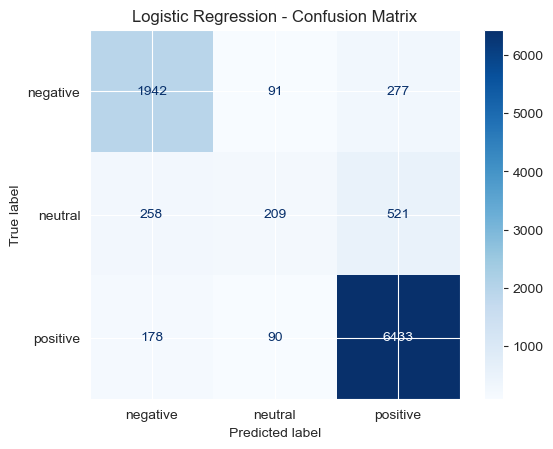

In [81]:
# Logistic Regression confusion matrix
cm_lr = confusion_matrix(y_test, y_pred, labels=['negative','neutral','positive'])
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=['negative','neutral','positive'])
disp_lr.plot(cmap='Blues')
plt.title("Logistic Regression - Confusion Matrix")
plt.show()


**Observation:** The confusion matrix reveals strong performance on positive and negative classes, with most errors occurring in neutral sentiment classification.


### Confusion Matrix - Naive Bayes

Visualize prediction patterns for the Naive Bayes model to compare with Logistic Regression.


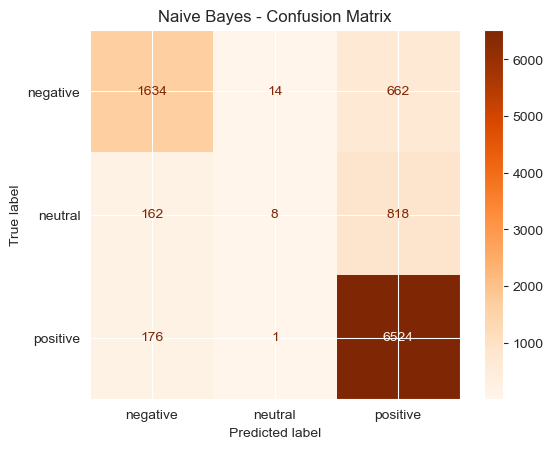

In [82]:

# Naive Bayes confusion matrix
cm_nb = confusion_matrix(y_test, y_pred_nb, labels=['negative','neutral','positive'])
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=['negative','neutral','positive'])
disp_nb.plot(cmap='Oranges')
plt.title("Naive Bayes - Confusion Matrix")
plt.show()

**Observation:** Naive Bayes shows similar patterns but with lower overall accuracy, particularly struggling to identify neutral reviews correctly.


### Confusion Matrix - Naive Bayes

Visualize prediction patterns for the Naive Bayes model to compare with Logistic Regression.


C:\Users\aymen\AppData\Local\Temp\ipykernel_9736\3624566682.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette='Set2')


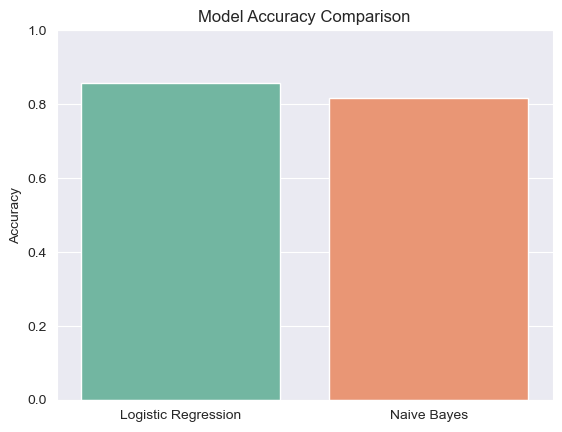

In [83]:
accuracies = {
    "Logistic Regression": 0.858,
    "Naive Bayes": 0.817
}

sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette='Set2')
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()


**Result:** Visual comparison confirms Logistic Regression's superior performance, demonstrating the value of incorporating numerical features alongside text data.


### Phase 7 Summary

Phase 7 evaluated and compared two machine learning models for sentiment classification. Naive Bayes served as a baseline using only TF-IDF text features, achieving 81.7% accuracy and demonstrating efficiency as a simple text classifier. Logistic Regression, incorporating both text and numerical features, achieved 85.8% accuracy, showing improved performance through richer feature representation. Confusion matrix analysis revealed that both models performed well on positive and negative sentiments but struggled with neutral reviews, highlighting the inherent ambiguity in moderately rated content. The comparison validates that comprehensive preprocessing, including text cleaning, TF-IDF transformation, and numerical feature engineering, significantly enhances model effectiveness and interpretability for sentiment analysis tasks.
